# Dataset

In [ ]:
from google.colab import drive
DRIVE_DIR = '/content/drive'
drive.mount(DRIVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configurações de Resultados do Notebook

In [ ]:
from os.path import join

mydrive_folder = join(DRIVE_DIR, 'MyDrive')

figs_folder = join(
    mydrive_folder,
    'MOD MAT INTELIG ARTIFICIAL',
    'Imagens Artigo'
) # onde se salvam os resultados

dataset_file = join(
    mydrive_folder,
    'MOD MAT INTELIG ARTIFICIAL',
    '[att] Database of punching shear resistance of FRP reinforced concrete slabs.xlsx'
)

# Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Abrindo dataset
dataset = pd.read_excel(dataset_file, sheet_name='Artigo')
dataset = dataset.drop('c1', axis='columns')
dataset = dataset.drop('b1', axis='columns')


## Verificando Outliers


Código desenvolvido considerando <a href="https://sgmd.nute.ufsc.br/content/especializacao-cultura-digital/letramento-estatistico/pagina-20.html">Gráfico da curva normal</a>



In [ ]:
# Removendo outlayers considerando um número n de desvios
n_desvios = 3
valores_a_remover = [] # linhas a serem removidas

for key in dataset.keys():
  coluna = dataset[key]

  # Calcular limites de controle sem outliers
  q1 = coluna.quantile(0.25)
  q3 = coluna.quantile(0.75)
  iqr = q3 - q1
  limite_inf = q1 - n_desvios * 0.5 * iqr
  limite_sup = q3 + n_desvios * 0.5 * iqr

  # Printando resultados
  txt0 = f'{key}'.ljust(5)
  txt1 = f'{limite_sup:.2f}'.rjust(7)
  txt2 = f'{limite_inf:.2f}'.rjust(7)
  txt3 = f'{0.5 * iqr:.2f}'.rjust(7)
  print(f'Coluna: {txt0} Limite sup: {txt1} Limite inf: {txt2} Desvio: {txt3}')

  for i, value in enumerate(coluna):
    if not limite_inf <= value <= limite_sup:
      valores_a_remover.append(i)

n_linhas = dataset.shape[0]
n_remocoes = len(np.unique(valores_a_remover))
valores_a_remover = np.unique(valores_a_remover)
print(f'Número de dados a serem removidos: {n_remocoes} de {n_linhas}')
print(f'Dados restantes considerando {n_desvios} desvios: {n_linhas - n_remocoes}')

Coluna: B1    Limite sup: 4300.00 Limite inf: -500.00 Desvio:  600.00
Coluna: C1    Limite sup: 3425.00 Limite inf:   25.00 Desvio:  425.00
Coluna: Acol  Limite sup: 1912.50 Limite inf: -787.50 Desvio:  337.50
Coluna: d'    Limite sup:  246.25 Limite inf:    4.25 Desvio:   30.25
Coluna: fc    Limite sup:   71.38 Limite inf:    8.78 Desvio:    7.82
Coluna: Ef    Limite sup:  181.60 Limite inf:  -36.00 Desvio:   27.20
Coluna: ρf    Limite sup:    2.35 Limite inf:   -0.71 Desvio:    0.38
Coluna: Pu    Limite sup:  948.50 Limite inf: -259.50 Desvio:  151.00
Número de dados a serem removidos: 30 de 183
Dados restantes considerando 3 desvios: 153


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1) # utilizado para o paper

def plot_botplot(dataset: pd.DataFrame, fig_name: str):
  fig = plt.figure(figsize=(10,7))
  sns.boxplot(data=dataset)
  # sns.set(font_scale=2) # utilizado para o paper
  plt.tight_layout()
  plt.savefig(fig_name)


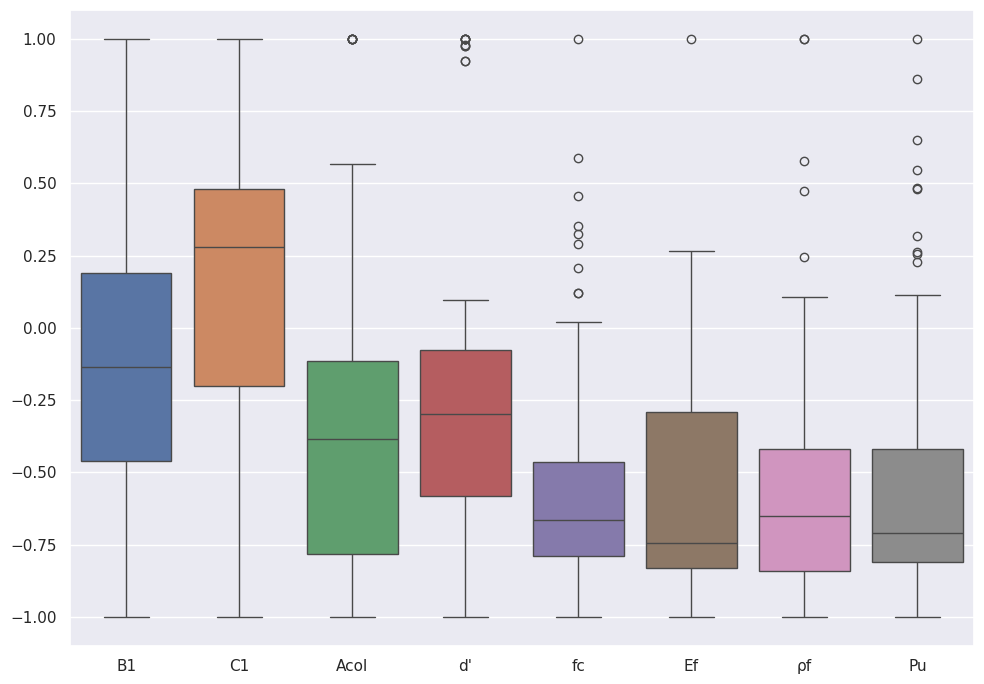

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizando Dataset para análise
dataset_scaler = MinMaxScaler(feature_range=(-1, 1))
dataset_scaled = pd.DataFrame(dataset_scaler.fit_transform(dataset), columns=dataset.columns)

plot_botplot(
    dataset_scaled,
    join(figs_folder, 'box_plot_outliers.png')
)

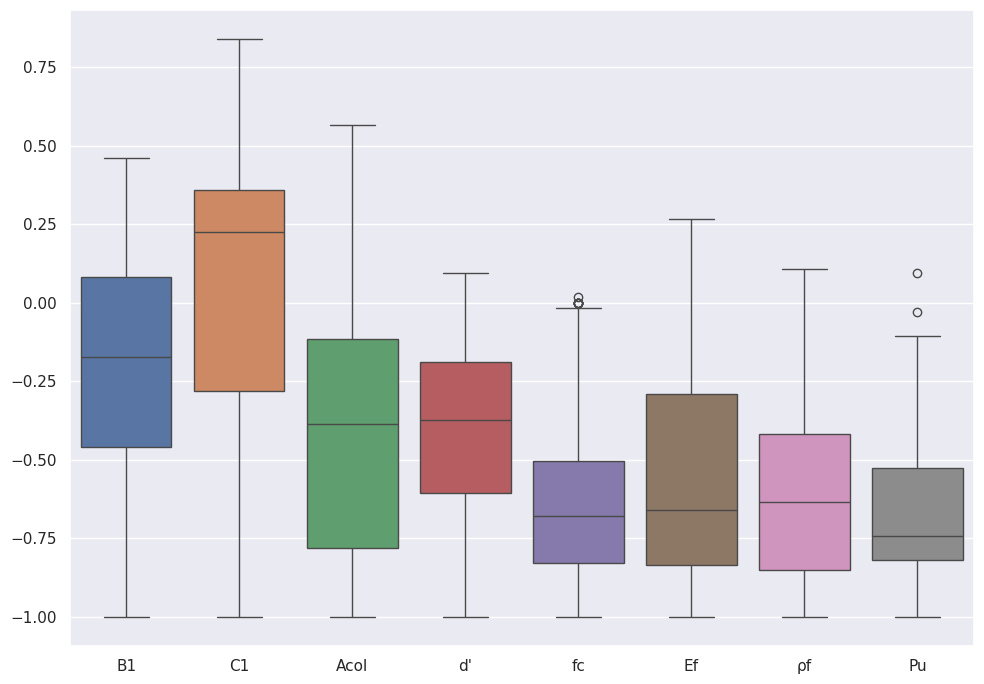

In [ ]:
plot_botplot(
    dataset_scaled.drop(valores_a_remover),
    join(figs_folder, 'box_plot_outliers_removidos.png')
)

## Histogramas antes da remoção de outliers

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def mostrar_histograma(dataset, save_figures=False):
  for fig_index,coluna in enumerate(dataset.columns):
    plt.figure(figsize=(8, 6))
    plt.hist(dataset[coluna], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Data distribution for column {coluna}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    if save_figures==True:
      fig_folder = f'{figs_folder}/histograma_{fig_index}.png'
      print(fig_folder)
      plt.savefig(fig_folder)
    plt.show()

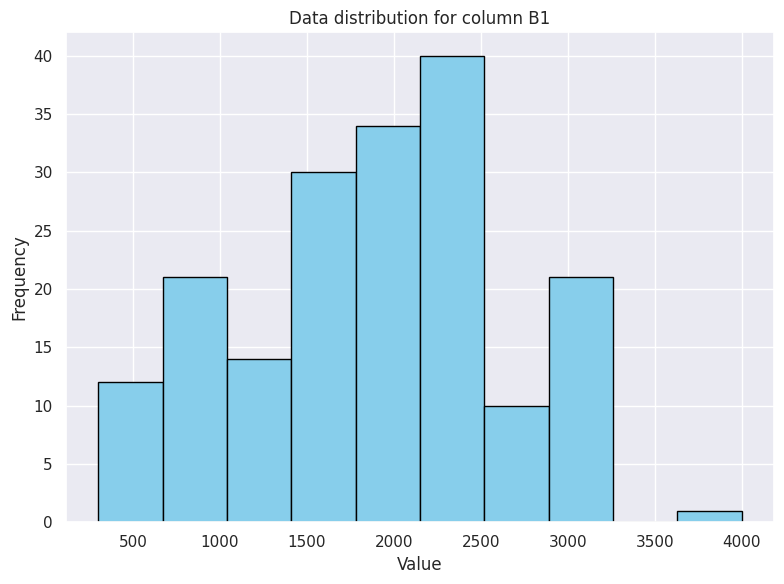

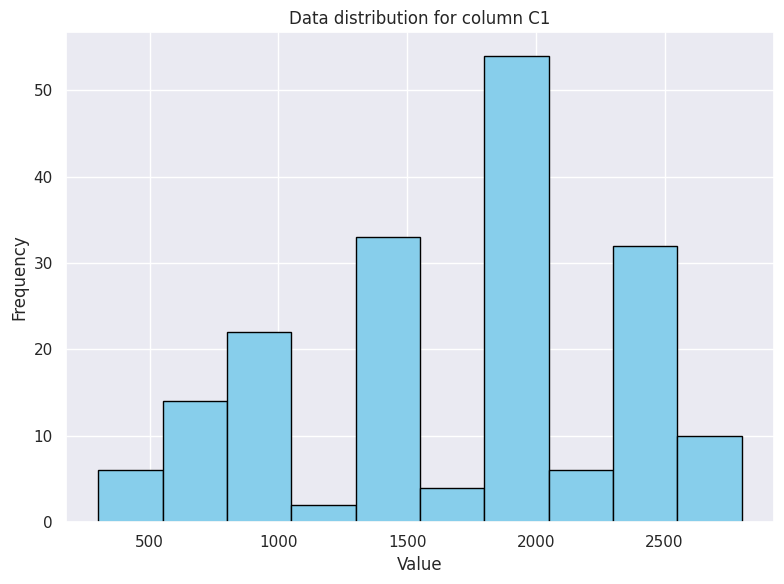

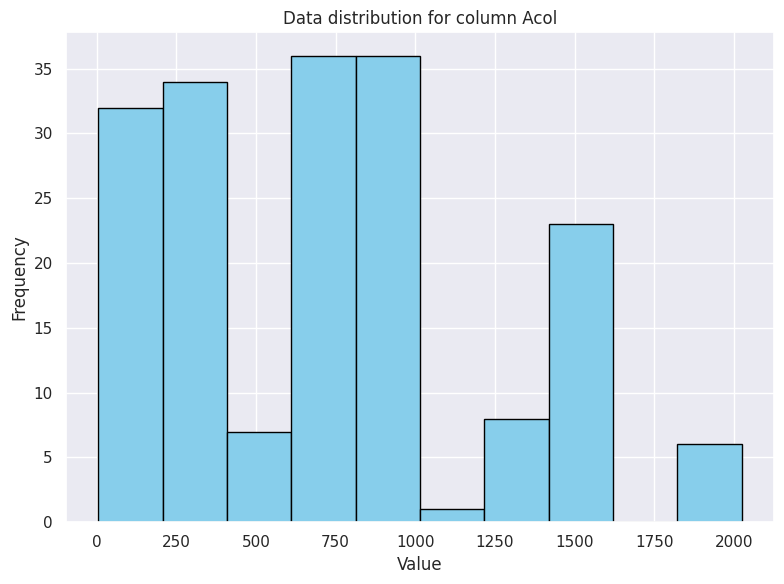

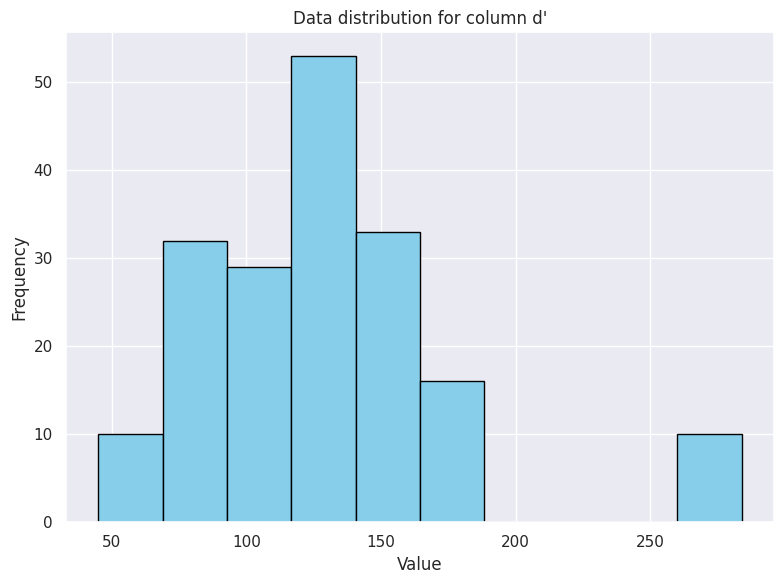

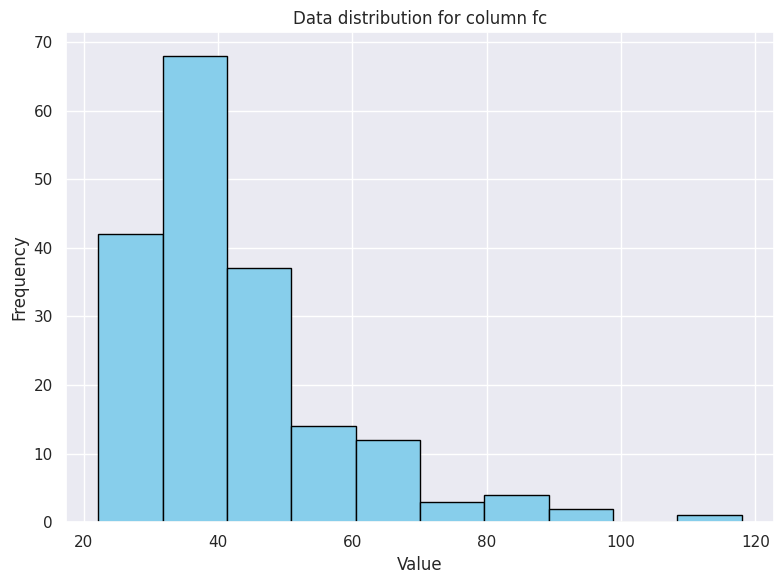

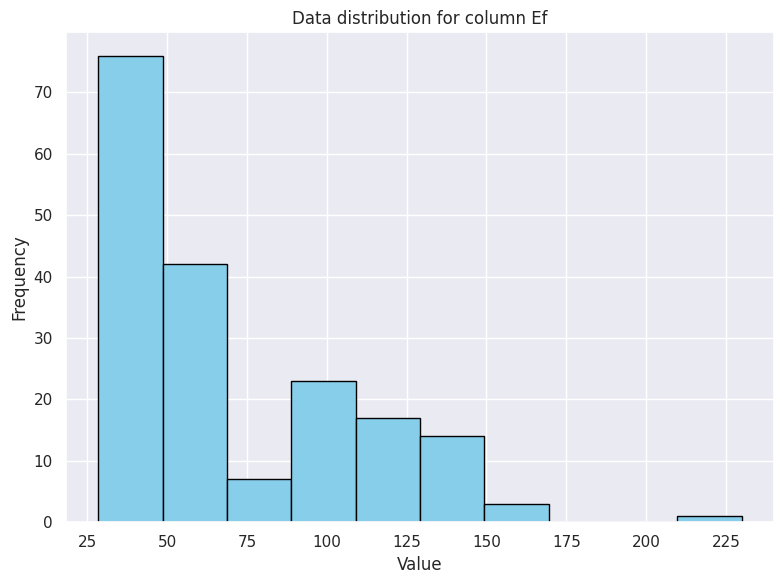

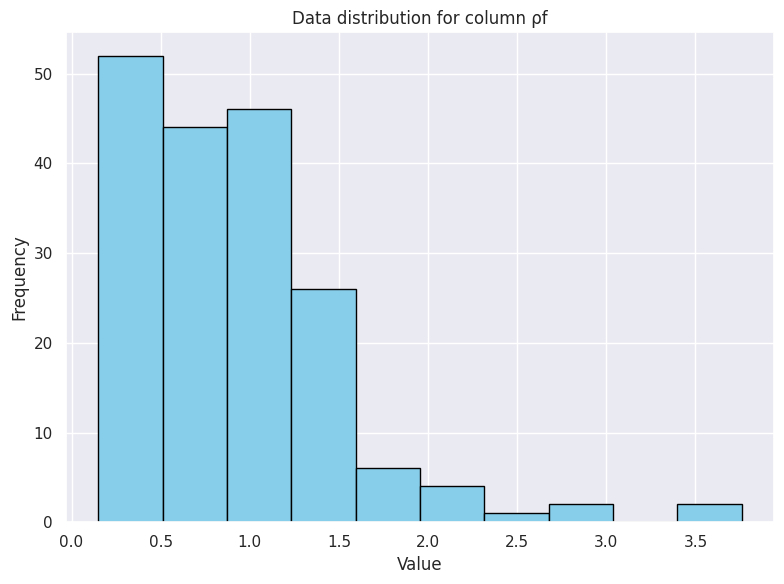

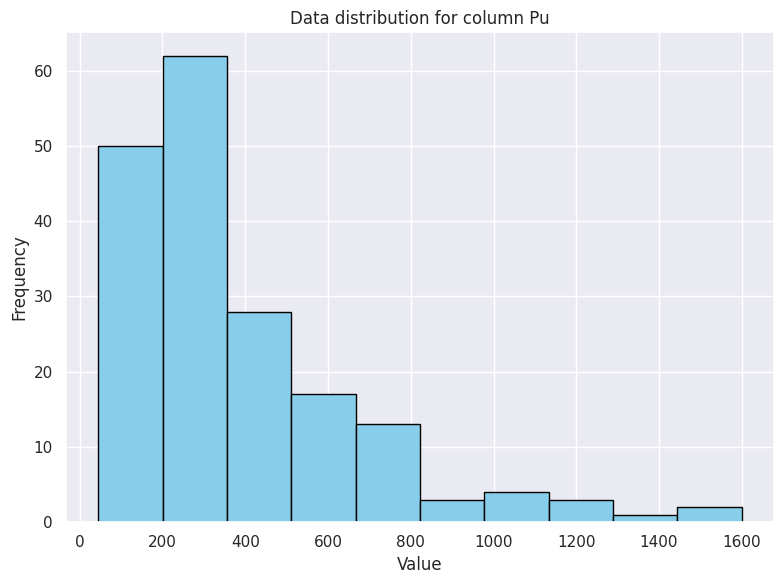

In [ ]:
mostrar_histograma(dataset, save_figures=False)

Removendo outlayers do dataset

In [ ]:
dataset = dataset.drop(valores_a_remover)

# DIVISÃO DOS DADOS EM ENTRADA E SAÍDA
n_colunas = dataset.shape[1] - 1
data = np.array(dataset)
entrada = pd.DataFrame(data[:, 0:n_colunas])  # Features: B1, C1, b1, c1, Acol, d', fc, Ef, pf
saida = pd.DataFrame(data[:, n_colunas])  # Target: Pu

## Divindo Treino e Teste

In [ ]:
from sklearn.model_selection import train_test_split

# DIVISÃO DOS DADOS EM CONJUNTOS DE TREINAMENTO E TESTE
X_train, X_test, y_train, y_test = train_test_split(entrada, saida, test_size=0.20, random_state = 53, shuffle = True)

print(f'Train: {len(X_train)}. Test: {len(X_test)}')

Train: 122. Test: 31


## Normalizando Dados

In [ ]:
# REESCALANDO DADOS
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

X_train_n = X_scaler.fit_transform(X_train)
X_test_n = X_scaler.transform(X_test)

y_train_n = np.ravel(y_scaler.fit_transform(y_train))
y_test_n = np.ravel(y_scaler.transform(y_test))

In [ ]:
print(np.min(X_train_n), np.max(X_train_n))
print(np.min(X_test_n), np.max(X_test_n))

-1.0 1.0000000000000002
-1.25 1.040816326530612


In [ ]:
print(np.min(y_train_n), np.max(y_train_n))
print(np.min(y_test_n), np.max(y_test_n))

-1.0 1.0000000000000004
-1.0285714285714285 0.7666666666666668


## Analisando Correlações

# Não é necessário a categoria nessa etapa para análise de dados
peason não é possível utilizar variáveis com outliers
<a href="https://www.atlassian.com/data/charts/box-plot-complete-guide#:~:text=Construction%20of%20a%20box%20plot,also%20known%20as%20the%20median.">Referência</a>



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_corr(corr, title):
  annot_fontsize = 14
  title_fontsize = 14
  xlabel_fontsize = 12
  ylabel_fontsize = 12

  fig = plt.figure(figsize=(10,8))

  ax = sns.heatmap(
      corr,
      vmin=-1,
      vmax=1,
      center=0,
      square=True,
      annot=True,
      annot_kws={"size": annot_fontsize},  # Aumenta o tamanho das anotações
      linewidths=0.8,
      cbar_kws={'shrink': .75},  # Ajusta a barra de cores se necessário
      cbar=False  # Remove a legenda (barra de cores)
  )

  ax.set_ylim(len(corr), 0)

  # Ajuste o tamanho da fonte do título
  plt.title(title, fontsize=title_fontsize)

  # Ajuste o tamanho da fonte dos rótulos dos eixos
  ax.set_xlabel(ax.get_xlabel(), fontsize=xlabel_fontsize)
  ax.set_ylabel(ax.get_ylabel(), fontsize=ylabel_fontsize)

  plt.tight_layout()
  plt.savefig(join(figs_folder, f'{title}.png'))
  plt.show()

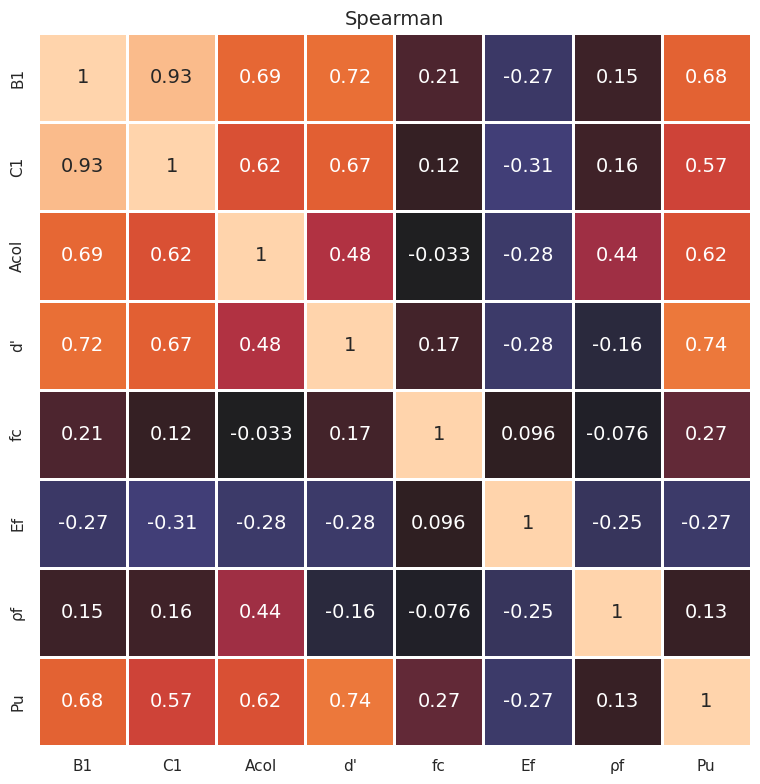

In [ ]:
spearman=dataset.iloc[1:,:].corr(method='spearman')
show_corr(spearman, 'Spearman')

## Histogramas após remoção de outliers

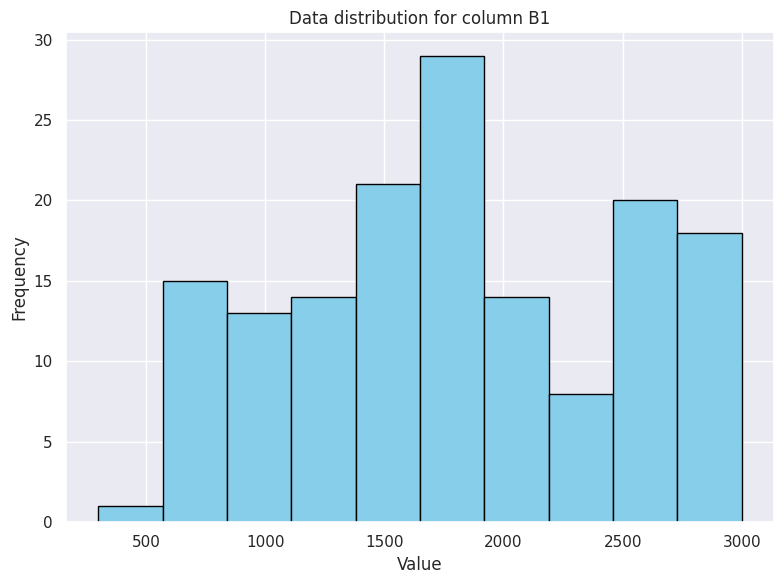

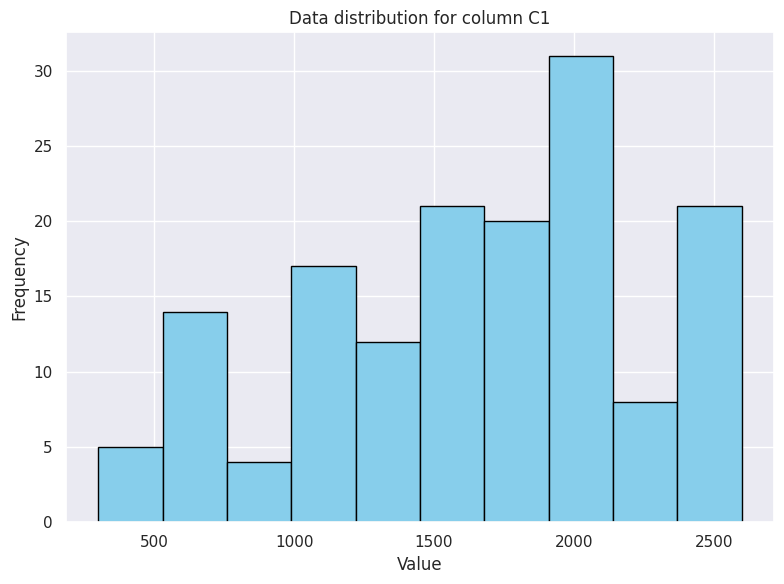

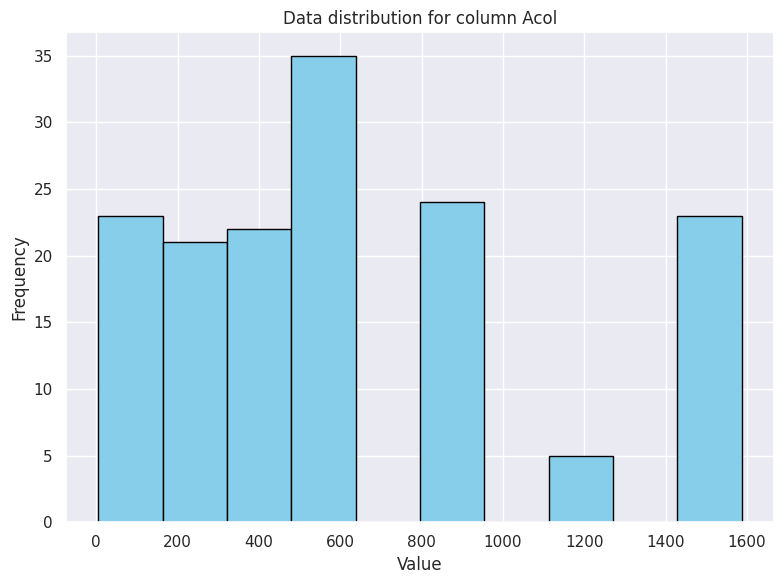

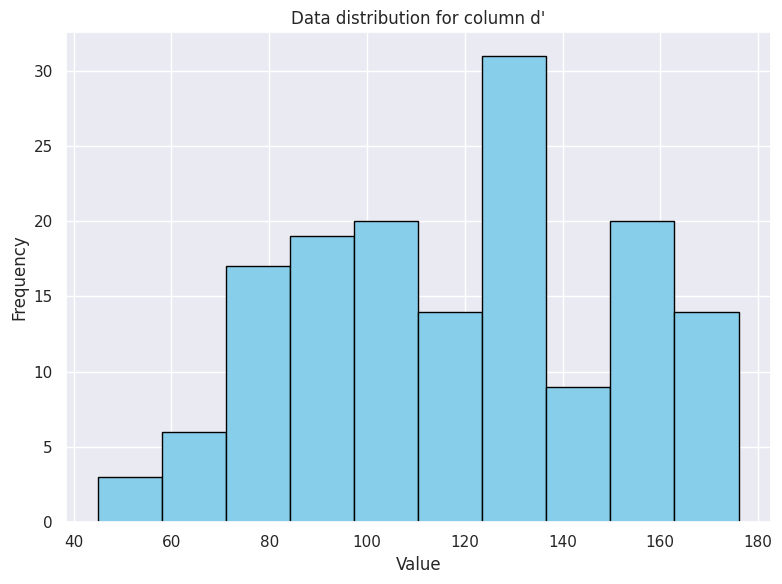

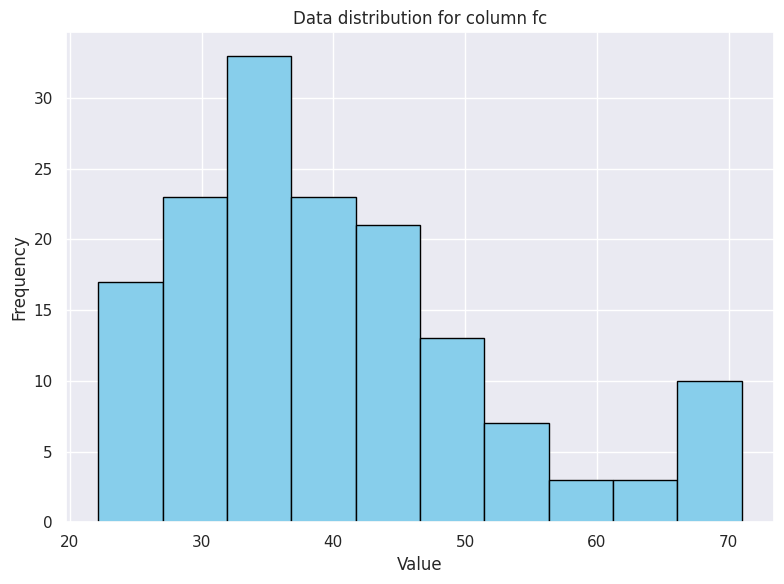

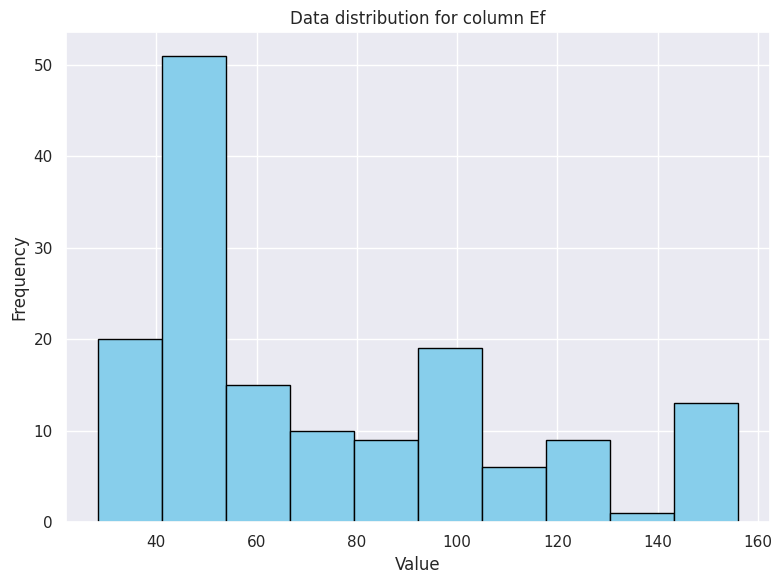

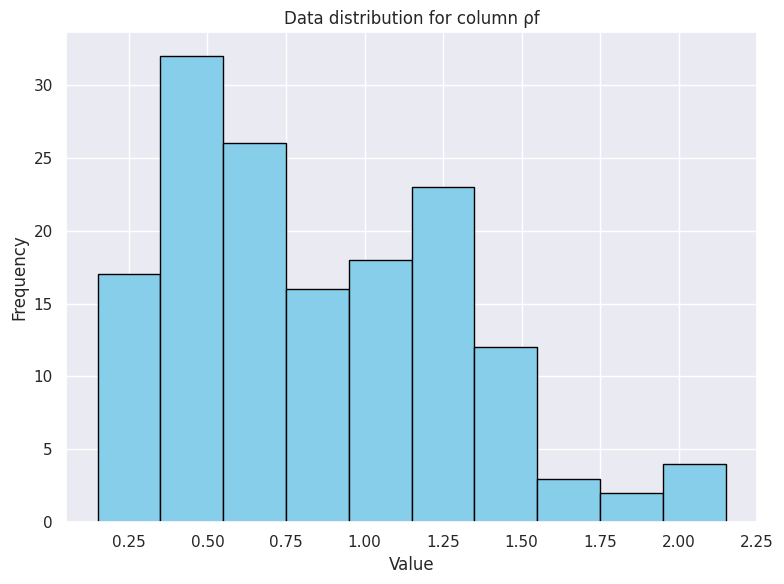

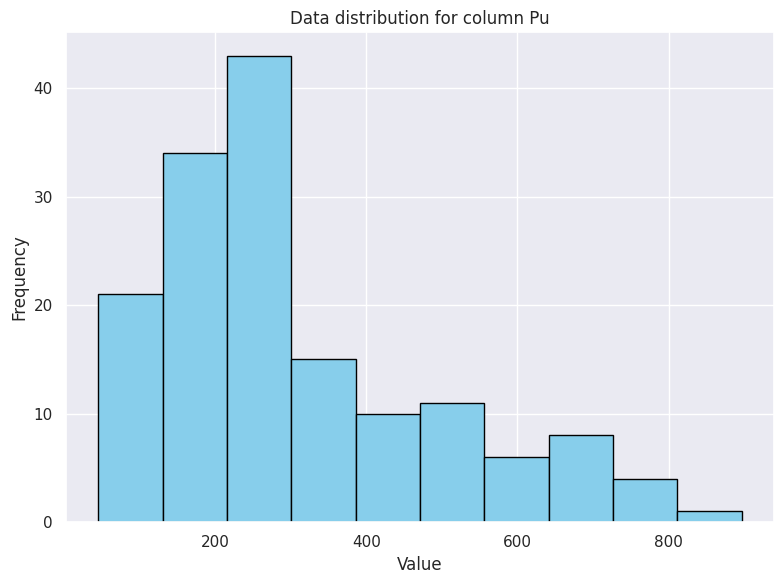

In [ ]:
mostrar_histograma(dataset, save_figures=False)

# Modelos

## SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import os

svm_Model = SVR()

svm_params = [
    {
        'kernel' : ['poly', 'rbf', 'sigmoid'],
        'C': [0.05, 0.1, 0.5, 0.8, 1.0],
        'max_iter' : [1000],
        'degree' : [2, 3, 4, 5]
    }
]

svm_grid = GridSearchCV(
    estimator = svm_Model,
    param_grid = svm_params,
    cv = 10, # k-fold,
    scoring = 'r2',
    n_jobs = int(os.cpu_count())
)

svm_grid.fit(X_train_n, y_train_n)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=2,
             param_grid=[{'C': [0.05, 0.1, 0.5, 0.8, 1.0],
                          'degree': [2, 3, 4, 5],
                          'kernel': ['poly', 'rbf', 'sigmoid'],
                          'max_iter': [1000]}],
             scoring='r2')

## Redes Neurais

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import os

nn_Model = MLPRegressor()

n_colunas = dataset.shape[1]

nn_params = [{
    'hidden_layer_sizes' : [(n_colunas), (n_colunas*2), (n_colunas*2, n_colunas*2)],
    'activation' : ["logistic", "relu", "tanh"],
    'solver' : ["lbfgs"],
    'learning_rate_init' : [0.1, 0.01],
    'max_iter' : [2000],
    'shuffle' : [False],
    'early_stopping' : [True],
    'random_state' : [6,13,17,42],
    'batch_size' : [1]
}]

nn_grid = GridSearchCV(
    estimator = nn_Model,
    param_grid = nn_params,
    cv = 10, # k-fold
    scoring = 'r2',
    n_jobs = int(os.cpu_count())
)

nn_grid.fit(X_train_n, y_train_n)

GridSearchCV(cv=10, estimator=MLPRegressor(), n_jobs=2,
             param_grid=[{'activation': ['logistic', 'relu', 'tanh'],
                          'batch_size': [1], 'early_stopping': [True],
                          'hidden_layer_sizes': [8, 16, (16, 16)],
                          'learning_rate_init': [0.1, 0.01], 'max_iter': [2000],
                          'random_state': [6, 13, 17, 42], 'shuffle': [False],
                          'solver': ['lbfgs']}],
             scoring='r2')

## Arvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import os

dt_Model = DecisionTreeRegressor()

dt_params = [{
    'criterion' : ['squared_error', 'absolute_error'],
    'max_depth' : [3, 4, 5, 6],
    'min_samples_split' : [2, 3],
    'min_samples_leaf' : [1, 3],
    'random_state' : [6,13,17,42]
}]

dt_grid = GridSearchCV(
    estimator = dt_Model,
    param_grid = dt_params,
    cv = 10, # k-fold
    scoring = 'r2',
    n_jobs = int(os.cpu_count())
)

dt_grid.fit(X_train_n, y_train_n)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=2,
             param_grid=[{'criterion': ['squared_error', 'absolute_error'],
                          'max_depth': [3, 4, 5, 6], 'min_samples_leaf': [1, 3],
                          'min_samples_split': [2, 3],
                          'random_state': [6, 13, 17, 42]}],
             scoring='r2')

## Verificando Parâmetros

In [ ]:
svm_grid.best_params_

{'C': 1.0, 'degree': 5, 'kernel': 'poly', 'max_iter': 1000}

In [ ]:
nn_grid.best_params_

{'activation': 'logistic',
 'batch_size': 1,
 'early_stopping': True,
 'hidden_layer_sizes': (16, 16),
 'learning_rate_init': 0.1,
 'max_iter': 2000,
 'random_state': 6,
 'shuffle': False,
 'solver': 'lbfgs'}

In [ ]:
dt_grid.best_params_

{'criterion': 'squared_error',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'random_state': 17}

## Avaliando Métricas

## Treino

In [ ]:
def make_pred(model, input):
  #PREDIÇÃO DO CONJUNTO DE TREINAMENTO
  saida_pred = model.predict(input)  # Predição no conjunto de treinamento
  saida_pred = y_scaler.inverse_transform(saida_pred.reshape(-1, 1))  # Desnormalizar os valores previstos
  return saida_pred

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def get_metrics(model):
  saida_pred_train = make_pred(model, X_train_n)
  # Métricas de avaliação para o conjunto de treinamento
  print("Métricas de Avaliação para Conjunto de Treinamento:")
  print("Erro Médio Absoluto (MAE):", mean_absolute_error(y_train, saida_pred_train))
  print("Erro Quadrático Médio (MSE):", mean_squared_error(y_train, saida_pred_train))
  print("Coeficiente de Determinação (R²):", r2_score(y_train, saida_pred_train))

In [ ]:
svm_model = svm_grid.best_estimator_
get_metrics(svm_model)

Métricas de Avaliação para Conjunto de Treinamento:
Erro Médio Absoluto (MAE): 40.50721014777745
Erro Quadrático Médio (MSE): 2534.774705187555
Coeficiente de Determinação (R²): 0.9255378589993587


In [ ]:
nn_model = nn_grid.best_estimator_
get_metrics(nn_model)

Métricas de Avaliação para Conjunto de Treinamento:
Erro Médio Absoluto (MAE): 11.107422670117439
Erro Quadrático Médio (MSE): 339.5628557034332
Coeficiente de Determinação (R²): 0.9900249212727967


In [ ]:
dt_model = dt_grid.best_estimator_
get_metrics(dt_model)

Métricas de Avaliação para Conjunto de Treinamento:
Erro Médio Absoluto (MAE): 32.55141265110117
Erro Quadrático Médio (MSE): 2285.353452972583
Coeficiente de Determinação (R²): 0.9328649166715763


## Teste

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def get_metrics(model):
  saida_pred_test = make_pred(model, X_test_n)
  # Métricas de avaliação para o conjunto de treinamento
  print("Métricas de Avaliação para Conjunto de Treinamento:")
  print("Erro Médio Absoluto (MAE):", mean_absolute_error(y_test, saida_pred_test))
  print("Erro Quadrático Médio (MSE):", mean_squared_error(y_test, saida_pred_test))
  print("Coeficiente de Determinação (R²):", r2_score(y_test, saida_pred_test))

In [ ]:
svm_model = svm_grid.best_estimator_
get_metrics(svm_model)

Métricas de Avaliação para Conjunto de Treinamento:
Erro Médio Absoluto (MAE): 73.10689756934356
Erro Quadrático Médio (MSE): 10539.672143845546
Coeficiente de Determinação (R²): 0.7055172920379429


In [ ]:
nn_model = nn_grid.best_estimator_
get_metrics(nn_model)

Métricas de Avaliação para Conjunto de Treinamento:
Erro Médio Absoluto (MAE): 55.107455518266626
Erro Quadrático Médio (MSE): 4715.823460061955
Coeficiente de Determinação (R²): 0.8682379827534801


In [ ]:
dt_model = dt_grid.best_estimator_
get_metrics(dt_model)

Métricas de Avaliação para Conjunto de Treinamento:
Erro Médio Absoluto (MAE): 57.87060312805473
Erro Quadrático Médio (MSE): 5583.070854781742
Coeficiente de Determinação (R²): 0.8440067393348456


# Analisando modelos

In [ ]:
tabela = pd.DataFrame(svm_grid.cv_results_)[['params', 'rank_test_score', 'mean_test_score']]

tabela_ordenada = tabela.sort_values(by='mean_test_score', ascending=False)
tabela_ordenada.to_excel(f'{figs_folder}/svm_grid.xlsx', index=False)
tabela_ordenada

,params,rank_test_score,mean_test_score
57,"{'C': 1.0, 'degree': 5, 'kernel': 'poly', 'max...",1,0.706349
45,"{'C': 0.8, 'degree': 5, 'kernel': 'poly', 'max...",2,0.701895
33,"{'C': 0.5, 'degree': 5, 'kernel': 'poly', 'max...",3,0.680400
52,"{'C': 1.0, 'degree': 3, 'kernel': 'rbf', 'max_...",4,0.678247
58,"{'C': 1.0, 'degree': 5, 'kernel': 'rbf', 'max_...",4,0.678247
55,"{'C': 1.0, 'degree': 4, 'kernel': 'rbf', 'max_...",4,0.678247
49,"{'C': 1.0, 'degree': 2, 'kernel': 'rbf', 'max_...",4,0.678247
43,"{'C': 0.8, 'degree': 4, 'kernel': 'rbf', 'max_...",8,0.665773
37,"{'C': 0.8, 'degree': 2, 'kernel': 'rbf', 'max_...",8,0.665773
40,"{'C': 0.8, 'degree': 3, 'kernel': 'rbf', 'max_...",8,0.665773


In [ ]:
tabela = pd.DataFrame(nn_grid.cv_results_)[['params', 'rank_test_score', 'mean_test_score']]

tabela_ordenada = tabela.sort_values(by='mean_test_score', ascending=False)
tabela_ordenada.to_excel(f'{figs_folder}/nn_grid.xlsx', index=False)
tabela_ordenada

,params,rank_test_score,mean_test_score
20,"{'activation': 'logistic', 'batch_size': 1, 'e...",1,0.809170
16,"{'activation': 'logistic', 'batch_size': 1, 'e...",1,0.809170
69,"{'activation': 'tanh', 'batch_size': 1, 'early...",3,0.761231
65,"{'activation': 'tanh', 'batch_size': 1, 'early...",3,0.761231
28,"{'activation': 'relu', 'batch_size': 1, 'early...",5,0.741992
...,...,...,...
51,"{'activation': 'tanh', 'batch_size': 1, 'early...",67,0.301156
53,"{'activation': 'tanh', 'batch_size': 1, 'early...",69,0.278240
49,"{'activation': 'tanh', 'batch_size': 1, 'early...",69,0.278240
60,"{'activation': 'tanh', 'batch_size': 1, 'early...",71,-0.057047


In [ ]:
tabela = pd.DataFrame(dt_grid.cv_results_)[['params', 'rank_test_score', 'mean_test_score']]

tabela_ordenada = tabela.sort_values(by='mean_test_score', ascending=False)
tabela_ordenada.to_excel(f'{figs_folder}/dt_grid.xlsx', index=False)
tabela_ordenada

,params,rank_test_score,mean_test_score
54,"{'criterion': 'squared_error', 'max_depth': 6,...",1,0.815519
50,"{'criterion': 'squared_error', 'max_depth': 6,...",2,0.810094
53,"{'criterion': 'squared_error', 'max_depth': 6,...",3,0.806838
55,"{'criterion': 'squared_error', 'max_depth': 6,...",4,0.805744
51,"{'criterion': 'squared_error', 'max_depth': 6,...",5,0.798263
...,...,...,...
78,"{'criterion': 'absolute_error', 'max_depth': 3...",121,0.602201
75,"{'criterion': 'absolute_error', 'max_depth': 3...",121,0.602201
76,"{'criterion': 'absolute_error', 'max_depth': 3...",121,0.602201
77,"{'criterion': 'absolute_error', 'max_depth': 3...",121,0.602201


# Imagens

## Ajuste do treino

In [ ]:
import matplotlib.pyplot as plt

def plot_trend(model, x_input, y_true, title='', color='black',save_fig=False):
  fig = plt.figure(figsize=(9, 5))

  x = np.array(range(len(y_true)))
  pred = make_pred(model, x_input)

  plt.plot(x, pred, 'k--', color=color, label='Foretold') # Linha tracejada azul
  plt.plot(x, y_true, 'go', label='Observed') # Green Bolinha

  plt.legend()

  plt.title(title)

  plt.grid(True)
  plt.xlabel('Samples')
  plt.ylabel('Answers')

  plt.show()

  if save_fig:
    plt.savefig(f'{title}_trend.png', format='png')

<ipython-input-244-0de299e8acdd>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, pred, 'k--', color=color, label='Foretold') # Linha tracejada azul


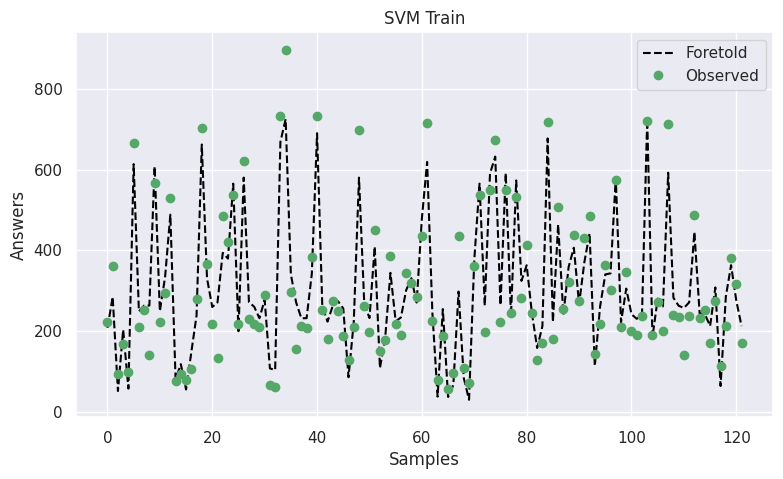

In [ ]:
plot_trend(svm_grid.best_estimator_, X_train_n, y_train, title='SVM Train')

<ipython-input-244-0de299e8acdd>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, pred, 'k--', color=color, label='Foretold') # Linha tracejada azul


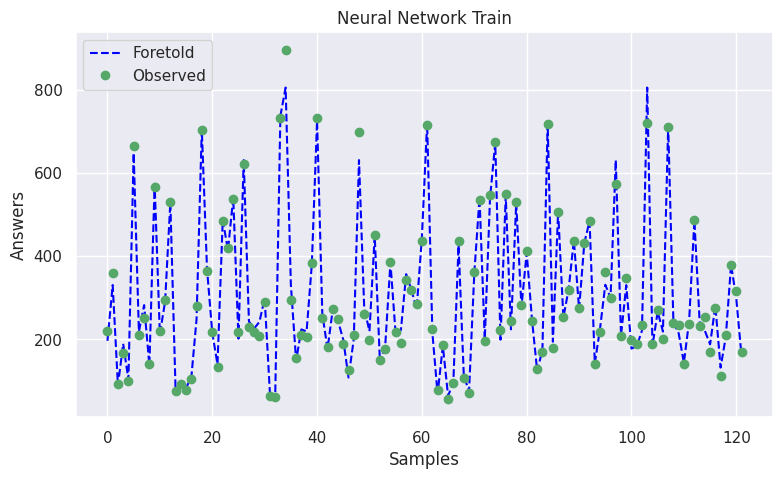

In [ ]:
plot_trend(nn_grid.best_estimator_, X_train_n, y_train, title='Neural Network Train', color='blue')

<ipython-input-244-0de299e8acdd>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, pred, 'k--', color=color, label='Foretold') # Linha tracejada azul


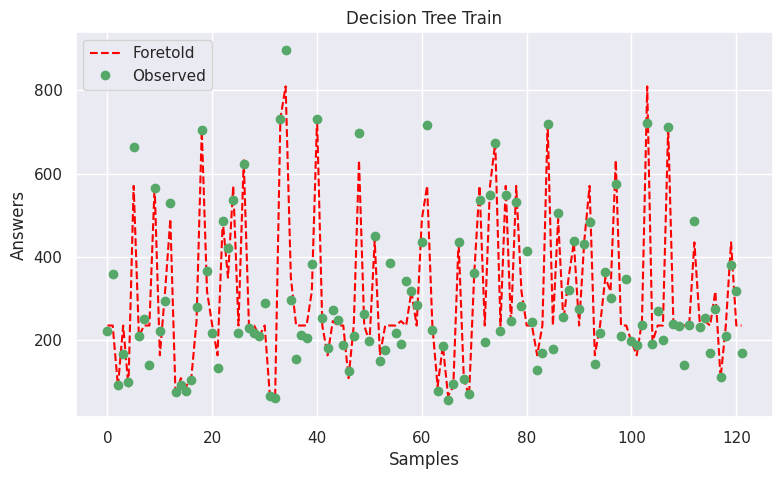

In [ ]:
plot_trend(dt_grid.best_estimator_, X_train_n, y_train, title='Decision Tree Train', color='red')

## Ajuste do teste

<ipython-input-244-0de299e8acdd>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, pred, 'k--', color=color, label='Foretold') # Linha tracejada azul


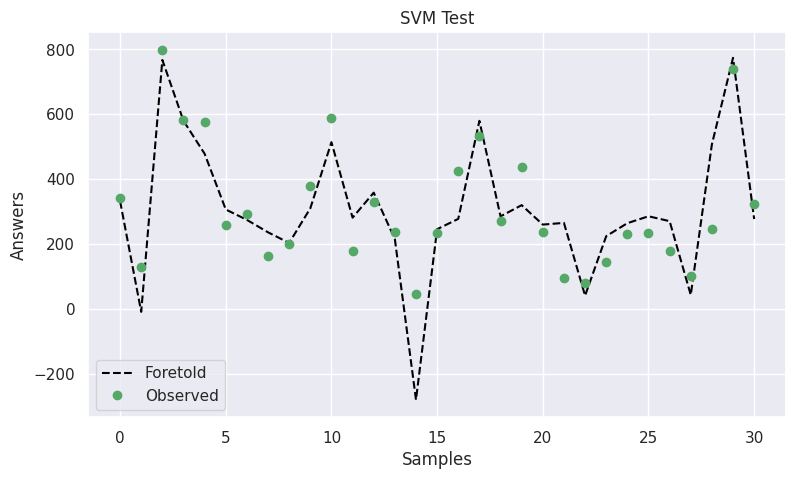

In [ ]:
plot_trend(svm_grid.best_estimator_, X_test_n, y_test, title='SVM Test')

<ipython-input-244-0de299e8acdd>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, pred, 'k--', color=color, label='Foretold') # Linha tracejada azul


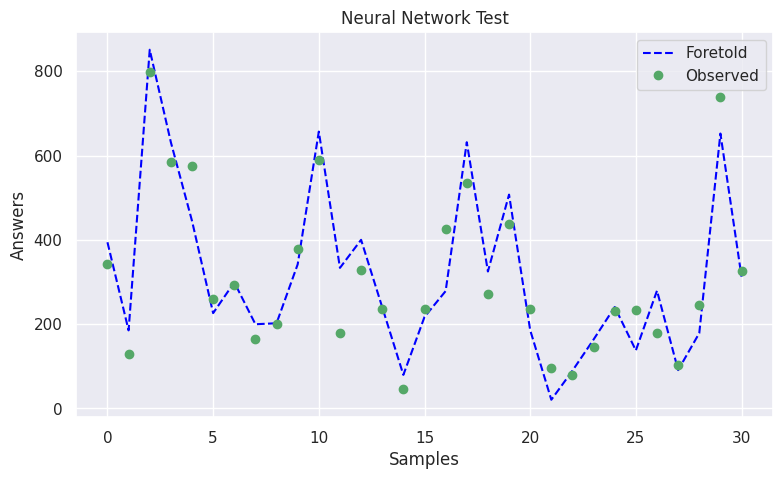

In [ ]:
plot_trend(nn_grid.best_estimator_, X_test_n, y_test, title='Neural Network Test', color='blue')

<ipython-input-244-0de299e8acdd>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, pred, 'k--', color=color, label='Foretold') # Linha tracejada azul


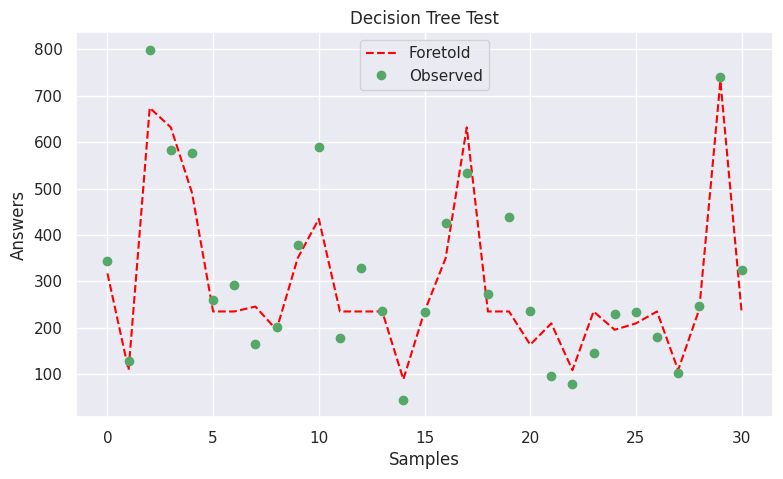

In [ ]:
plot_trend(dt_grid.best_estimator_, X_test_n, y_test, title='Decision Tree Test', color='red')

# Tempo de inferência

In [ ]:
import time

# Função para calcular o tempo de inferência
def calculate_inference_time(model, X_test_n):
    start_time = time.time()
    make_pred(model, X_test_n)
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Converte o tempo para milissegundos
    return inference_time

inferencias_svm = []
inferencias_nn = []
inferencias_dt = []

# MÉDIA DE INFERÊNCIA PARA UM DETERMINADO NÚMERO DE ITERAÇÕES
for _ in range(1_001):
  # Calcular o tempo de inferência para cada modelo
  inferencias_svm.append(calculate_inference_time(svm_grid.best_estimator_, X_test_n))
  inferencias_nn.append(calculate_inference_time(nn_grid.best_estimator_, X_test_n))
  inferencias_dt.append(calculate_inference_time(dt_grid.best_estimator_, X_test_n))

time_model1 = sum(inferencias_svm) / len(inferencias_svm)
time_model2 = sum(inferencias_nn) / len(inferencias_nn)
time_model3 = sum(inferencias_dt) / len(inferencias_dt)

print(f"Tempo de inferência do Model 1 (Suport Vector Machine): {time_model1:.6f} ms")
print(f"Tempo de inferência do Model 2 (Neural Network): {time_model2:.6f} ms")
print(f"Tempo de inferência do Model 3 (Decision Treee): {time_model3:.6f} ms")


Tempo de inferência do Model 1 (Suport Vector Machine): 0.368161 ms
Tempo de inferência do Model 2 (Neural Network): 0.282627 ms
Tempo de inferência do Model 3 (Decision Treee): 0.218280 ms
